#

This notebook evaluate the releases

# Imports

In [1]:
import datetime
import json

## Data Analysis

In [2]:
# %matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
pd.options.display.max_rows = 1000

from scipy.stats import wilcoxon
from scipy.stats import ranksums

##  Releasy development version

In [3]:
import os
import sys

releasy_module = os.path.abspath(os.path.join('..','..','..','dev','releasy'))
if releasy_module not in sys.path:
    sys.path.insert(0, releasy_module)

In [4]:
for mod in sorted(sys.modules.keys()):
    if mod.startswith("releasy"):
        del sys.modules[mod]

In [5]:
from releasy.miner.vcs.miner import Miner
from releasy.miner.vcs.git import GitVcs

In [6]:
from releasy.miner.vcs import miner as releasy_miner
from releasy.miner.vcs import git as releasy_git

In [7]:
import releasy

In [8]:
import importlib
importlib.reload(releasy_miner)
importlib.reload(releasy_git)

<module 'releasy.miner.vcs.git' from '/home/felipecrp/dev/releasy/releasy/miner/vcs/git.py'>

# Dataset setup

## Variables

In [9]:
repo_path = os.path.join('..','..','..','repos')

In [10]:
projects = pd.read_pickle("projects.zip")
projects["data"] = None

### Mining projects using Releasy

  - Currently, the **track_base_release** param has some performance issues. So to enable rapid mining, it is recommended to disable this param.
  
```{python}
params = {
    "track_base_release": False
}
```

In [11]:
release_mine_params = {}
release_mine_params["curl/curl"] = {
    "version_separator": "_"
}
release_mine_params["php/php-src"] = {
    "version_separator": "_|."
}

In [12]:
def mine_projects(mine_commits=False):
    count = 1
    projects["data"] = None
    for name, project in projects[(projects.data.isnull())].iterrows():
        print(f"{datetime.datetime.now()} - {count:3} - Processing {name}")
        project_group, project_name = name.split("/") 
        path = os.path.join(repo_path, project_group, f"{project_name}.git")
        projects.loc[name, "path"] = path    

        mine_params = {
            "track_base_release": False
        }
        if name in release_mine_params:
            mine_params.update(release_mine_params[name])
        miner = releasy_miner.Miner(name=name,vcs=releasy_git.GitVcs(path), **mine_params)
        project = miner.mine_releases()
        if mine_commits:
            project = miner.mine_commits()
        projects.loc[name, "data"] = project
        count += 1
    print(f"{datetime.datetime.now()} - Ended")

mine_projects()

2020-01-13 20:21:58.852132 -   1 - Processing freeCodeCamp/freeCodeCamp
2020-01-13 20:21:58.854669 -   2 - Processing vuejs/vue
2020-01-13 20:21:58.865251 -   3 - Processing facebook/react
2020-01-13 20:21:58.870836 -   4 - Processing twbs/bootstrap
2020-01-13 20:21:58.874290 -   5 - Processing facebook/react-native
2020-01-13 20:21:58.920741 -   6 - Processing facebook/create-react-app
2020-01-13 20:21:58.930771 -   7 - Processing axios/axios
2020-01-13 20:21:58.933491 -   8 - Processing nodejs/node
2020-01-13 20:21:58.966088 -   9 - Processing FortAwesome/Font-Awesome
2020-01-13 20:21:58.969317 -  10 - Processing angular/angular.js
2020-01-13 20:21:58.978492 -  11 - Processing microsoft/vscode
2020-01-13 20:21:58.985389 -  12 - Processing microsoft/TypeScript
2020-01-13 20:21:58.990810 -  13 - Processing angular/angular
2020-01-13 20:21:59.002809 -  14 - Processing ant-design/ant-design
2020-01-13 20:21:59.013022 -  15 - Processing reduxjs/redux
2020-01-13 20:21:59.016035 -  16 - Pro

## Projects trial dataset

In [13]:
def gen_project_stats():
    projects["num_common_releases"] = projects["data"].apply(lambda p : len(p.get_releases(releasy.RELEASE_TYPE_COMMON)))
    projects["num_major_releases"] = projects["data"].apply(lambda p : len(p.get_releases(releasy.RELEASE_TYPE_MAJOR)))
    projects["num_minor_releases"] = projects["data"].apply(lambda p : len(p.get_releases(releasy.RELEASE_TYPE_MINOR)))
    projects["num_patch_releases"] = projects["data"].apply(lambda p : len(p.get_releases(releasy.RELEASE_TYPE_PATCH)))
    projects["num_duplicated_releases"] = projects["data"].apply(lambda p : len(p.get_releases(releasy.RELEASE_TYPE_DUPLICATED)))
    projects["num_pre_releases"] = projects["data"].apply(lambda p : len(p.get_releases(releasy.RELEASE_TYPE_PRE)))
    projects["num_releases"] = projects["data"].apply(lambda p : len(p.get_releases(releasy.RELEASE_TYPE_ANY)))
    projects["num_tags"] = projects["data"].apply(lambda p : len(p.tags))
    projects["per_releases"] = projects["num_releases"] / projects["num_tags"]
    projects["per_common_releases"] = projects["num_common_releases"] / projects["num_releases"]
    projects["per_pre_releases"] = projects["num_pre_releases"] / projects["num_releases"]
    projects["per_duplicated_releases"] = projects["num_duplicated_releases"] / projects["num_releases"]
    projects.fillna(0, inplace=True)
gen_project_stats()

### Promise: Projects often use tags to represent software releases

In [14]:
projects.loc[projects.per_releases > 0].count()[0] / projects.count()[0]

0.96

In [15]:
prj = projects.sort_values(by=["per_releases"], ascending=False).copy()

<IPython.core.display.Javascript object>


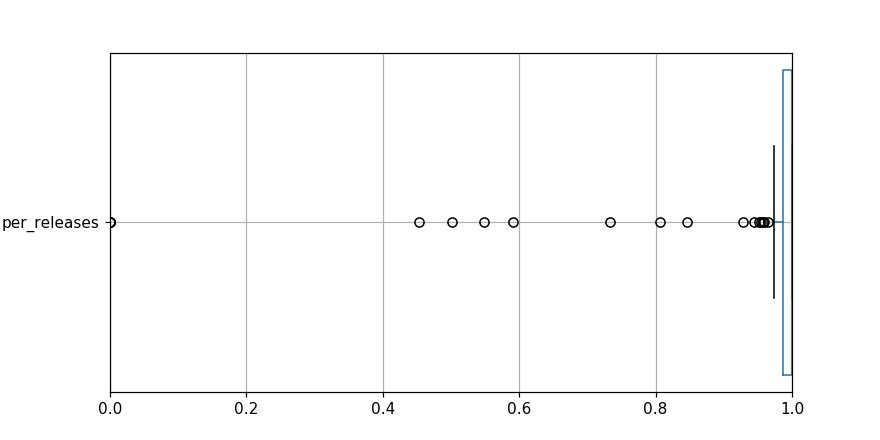

In [16]:
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(1,1,1)

ax.set_xlim([0,1])
prj.boxplot("per_releases", ax=ax, vert=False, widths=[0.9])



In [ ]:
ax.stackplot(
    np.arange(1,101),
    prj["per_common_releases"],
    prj["per_pre_releases"],
    #prj["per_duplicated_releases"]
)

<IPython.core.display.Javascript object>


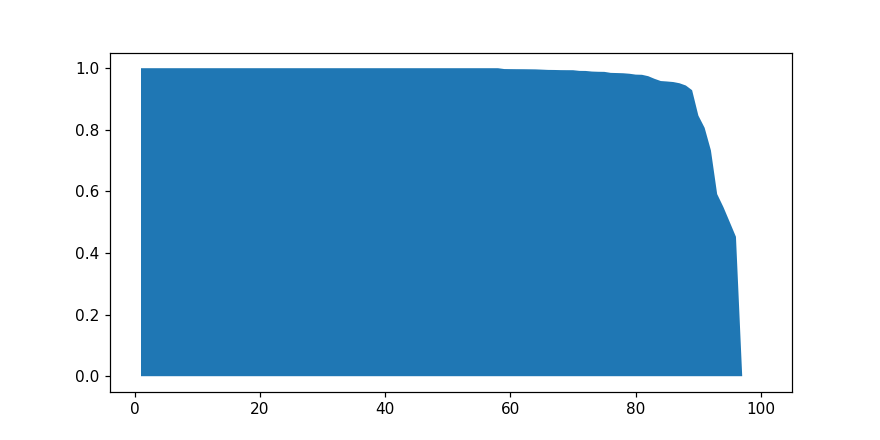

In [17]:
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(1,1,1)

ax.stackplot(np.arange(1,101),
             prj["per_releases"]
            )


In [ ]:
prj[["per_releases", "per_common_releases", "per_pre_releases","per_duplicated_releases"]]

In [18]:
for name, project in prj.iterrows():
    print(f"\n{name} {project.per_releases:0.2f} {project.num_releases:3}/{project.num_tags:3}")
    for tag in project["data"].tags:
        release = tag.release
        mark = "#"
        message = ""
        annotated = ":"
        if release:
            if release.is_type(releasy.RELEASE_TYPE_COMMON):
                mark = ""
            elif release.is_type(releasy.RELEASE_TYPE_PRE):
                mark = "p"
        else:
            mark = "-"        
        
        if tag.message:
            if tag.is_annotated:
                annotated = "a:"
            message = tag.message.replace('\n', ' ')[0:80]
        print(f"{mark:1} {tag.name:20} {annotated:2}{message}")


tensorflow/tensorflow 1.00  79/ 79
0.5.0
True
0.6.0
True
v0.6.0
False
v0.7.0
False
v0.7.1
False
v0.8.0rc0
False
v0.8.0
False
v0.9.0rc0
False
v0.9.0
False
v0.10.0rc0
False
v0.10.0
False
v0.11.0rc0
False
v0.11.0rc1
False
v0.11.0rc2
False
v0.11.0
False
0.12.0-rc0
False
0.12.0-rc1
False
v0.12.0
False
0.12.1
False
v1.0.0-alpha
False
v1.0.0-rc0
False
v1.0.0-rc1
False
v1.0.0-rc2
False
v1.0.0
False
v1.0.1
False
v1.1.0-rc0
False
v1.1.0-rc1
False
v1.1.0-rc2
False
v1.1.0
False
v1.2.0-rc0
False
v1.2.0-rc1
False
v1.2.0-rc2
False
v1.2.0
False
v1.2.1
False
v1.3.0-rc0
False
v1.3.0-rc1
False
v1.3.0-rc2
False
v1.3.0
False
v1.3.1
False
v1.4.0-rc0
False
v1.4.0-rc1
False
v1.4.0
False
v1.4.1
False
v1.5.0-rc0
False
v1.5.0-rc1
False
v1.5.0
False
v1.6.0-rc0
False
v1.6.0-rc1
False
v1.6.0
False
v1.7.0-rc0
False
v1.5.1
False
v1.7.0-rc1
False
v1.7.0
False
v1.8.0-rc0
False
v1.8.0-rc1
False
v1.8.0
False
tflite-v0.1.7
False
v1.7.1
False
v1.9.0-rc0
False
v1.9.0-rc1
False
v1.9.0-rc2
False
v1.9.0
False
v1.10.0-rc0
Fals

True
v1.8.3-beta.0
True
v1.6.12
True
v1.6.13-beta.0
True
v1.9.0-alpha.2
True
v1.7.10
True
v1.7.11-beta.0
True
v1.8.3
True
v1.8.4-beta.0
True
v1.9.0-alpha.3
True
v1.8.4
True
v1.8.5-beta.0
True
v1.9.0-beta.0
True
v1.10.0-alpha.0
True
v1.6.13
True
v1.6.14-beta.0
True
v1.7.11
True
v1.7.12-beta.0
True
v1.9.0-beta.1
True
v1.8.5
True
v1.8.6-beta.0
True
v1.9.0-beta.2
True
v1.9.0
True
v1.9.1-beta.0
True
v1.10.0-alpha.1
True
v1.8.6
True
v1.8.7-beta.0
True
v1.7.12
True
v1.7.13-beta.0
True
v1.9.1
True
v1.9.2-beta.0
True
v1.8.7
True
v1.8.8-beta.0
True
v1.9.2
True
v1.9.3-beta.0
True
v1.10.0-alpha.2
True
v1.10.0-alpha.3
True
v1.9.3
True
v1.9.4-beta.0
True
v1.8.8
True
v1.8.9-beta.0
True
v1.11.0-alpha.0
True
v1.10.0-beta.0
True
v1.7.13
True
v1.7.14-beta.0
True
v1.10.0-beta.1
True
v1.10.0-beta.2
True
v1.8.9
True
v1.8.10-beta.0
True
v1.7.14
True
v1.7.15-beta.0
True
v1.9.4
True
v1.9.5-beta.0
True
v1.10.0-beta.3
True
v1.10.0-beta.4
True
v1.7.15
True
v1.7.16-beta.0
True
v1.9.5
True
v1.9.6-beta.0
True
v1.8.1

True
v1.7.8.6
True
v1.7.9.7
True
v1.7.10.1
True
v1.7.10.2
True
v1.7.10.3
True
v1.7.11-rc0
True
v1.7.10.4
True
v1.7.11-rc1
True
v1.7.11-rc2
True
v1.7.11-rc3
True
v1.7.10.5
True
v1.7.11
True
v1.7.11.1
True
v1.7.11.2
True
v1.7.11.3
True
v1.7.12-rc0
True
v1.7.11.4
True
v1.7.12-rc1
True
v1.7.12-rc2
True
v1.7.11.5
True
v1.7.12-rc3
True
v1.7.12
True
v1.7.11.6
True
v1.7.11.7
True
v1.7.12.1
True
v1.7.12.2
True
v1.8.0-rc0
True
v1.7.12.3
True
v1.8.0-rc1
True
v1.8.0-rc2
True
v1.7.12.4
True
v1.8.0-rc3
True
gitgui-0.17.0
True
v1.8.0
True
v1.8.0.1
True
v1.8.1-rc0
True
v1.8.1-rc1
True
v1.8.0.2
True
v1.8.1-rc2
True
v1.8.1-rc3
True
v1.8.0.3
True
v1.8.1
True
v1.8.1.1
True
v1.8.1.2
True
v1.8.1.3
True
v1.8.2-rc0
True
v1.8.1.4
True
v1.8.2-rc1
True
v1.8.1.5
True
v1.8.2-rc2
True
v1.8.2-rc3
True
v1.8.2
True
v1.8.1.6
True
v1.8.2.1
True
v1.8.2.2
True
v1.8.3-rc0
True
v1.8.3-rc1
True
v1.8.2.3
True
v1.8.3-rc2
True
v1.8.3-rc3
True
v1.8.3
True
v1.8.3.1
True
gitgui-0.18.0
True
v1.8.3.2
True
v1.8.3.3
True
v1.8.3.4
True

v6.0.0-alpha1
True
v5.4.1
True
v5.3.3
True
v6.0.0-alpha2
True
v5.4.2
True
v5.4.3
True
v5.5.0
True
v2.4.6
False
v5.5.1
True
v6.0.0-beta1
True
v5.5.2
True
v6.0.0-beta2
True
v5.6.0
True
v5.5.3
True
v5.6.1
True
v5.6.2
True
v6.0.0-rc1
True
v5.6.3
True
v6.0.0-rc2
True
v5.6.4
True
v6.0.0
True
v5.6.5
True
v6.0.1
True
v6.1.0
True
v6.1.1
True
v5.6.6
True
v6.1.2
True
v5.6.7
True
v6.1.3
True
v6.2.0
True
v6.2.1
True
v6.2.2
True
v5.6.8
True
v6.2.3
True
v6.1.4
True
v5.6.9
True
v6.2.4
True
v6.3.0
True
v5.6.10
True
v6.3.1
True
v6.3.2
True
v6.4.0
False
v5.6.11
True
v6.4.1
True
v5.6.12
True
v6.4.2
True
v5.6.13
True
v6.4.3
True
v6.5.0
True
v6.5.1
True
v6.5.2
True
v5.6.14
True
v6.5.3
True
v7.0.0-alpha2
True
v7.0.0-alpha1
True
v6.5.4
True
v6.6.0
True
v7.0.0-beta1
True
v6.6.1
True
v5.6.15
True
v6.6.2
True
v5.6.16
True
v6.7.0
True
v7.0.0-rc1
True
v7.0.0-rc2
False
v6.7.1
True

fatedier/frp 1.00  50/ 50
v0.1.0
True
v0.2.0
True
v0.3.0
True
v0.5.0
True
v0.6.0
True
v0.7.0
True
v0.8.0
True
v0.8.1
True
v0.9.0
True
v

False
babel-preset-react-app@6.0.0
True
confusing-browser-globals@1.0.5
True
create-react-app@2.1.0
True
eslint-config-react-app@3.0.5
True
react-dev-utils@6.1.0
True
react-error-overlay@5.0.6
True
react-scripts@2.1.0
True
v2.1.0
False
v2.1.1
False
babel-plugin-named-asset-import@0.2.3
True
babel-preset-react-app@6.1.0
True
create-react-app@2.1.1
True
react-dev-utils@6.1.1
True
react-error-overlay@5.1.0
True
react-scripts@2.1.1
True
babel-plugin-named-asset-import@0.3.0
True
babel-preset-react-app@7.0.0
True
create-react-app@2.1.2
True
eslint-config-react-app@3.0.6
True
react-app-polyfill@0.2.0
True
react-dev-utils@7.0.0
True
react-error-overlay@5.1.1
True
react-scripts@2.1.2
True
v2.1.2
False
create-react-app@2.1.3
True
react-dev-utils@7.0.1
True
react-error-overlay@5.1.2
True
react-scripts@2.1.3
True
v2.1.3
False
v2.1.4
False
babel-plugin-named-asset-import@0.3.1
True
babel-preset-react-app@7.0.1
True
create-react-app@2.1.4
True
eslint-config-react-app@3.0.7
True
react-app-polyfill@0

angular/angular 0.99 309/311
2.0.0-alpha.13
False
starting
False
2.0.0-alpha.14
False
2.0.0-alpha.15
False
2.0.0-alpha.16
False
2.0.0-alpha.17
False
2.0.0-alpha.18
False
2.0.0-alpha.19
False
2.0.0-alpha.20
False
2.0.0-alpha.21
False
2.0.0-alpha.22
False
2.0.0-alpha.23
False
2.0.0-alpha.24
False
2.0.0-alpha.25
False
2.0.0-alpha.26
False
2.0.0-alpha.27
False
2.0.0-alpha.28
False
2.0.0-alpha.29
False
2.0.0-alpha.30
False
2.0.0-alpha.31
False
2.0.0-alpha.32
False
2.0.0-alpha.33
False
2.0.0-alpha.34
False
2.0.0-alpha.35
False
2.0.0-alpha.36
False
2.0.0-alpha.37
False
2.0.0-alpha.38
False
2.0.0-alpha.39
False
2.0.0-alpha.40
False
2.0.0-alpha.41
False
2.0.0-alpha.42
False
2.0.0-alpha.44
False
2.0.0-alpha.45
False
2.0.0-alpha.46
False
2.0.0-alpha.47
False
2.0.0-alpha.48
False
2.0.0-alpha.49
False
2.0.0-alpha.50
False
2.0.0-alpha.51
False
2.0.0-alpha.52
False
2.0.0-alpha.53
False
2.0.0-alpha.54
False
2.0.0-alpha.55
False
2.0.0-beta.0
False
2.0.0-beta.1
False
2.0.0-beta.2
False
2.0.0-beta.3
Fals

True
v4.0.1
True
v3.4.2
True
v4.0.2
True
v2.7.40
True
v2.8.33
True
v3.3.15
True
v3.4.3
True
v4.0.3
True
v2.7.41
True
v2.8.34
True
v3.3.16
True
v3.4.4
True
v4.0.4
True
v2.7.42
True
v2.8.35
True
v3.4.5
True
v4.0.5
True
v2.7.43
True
v2.8.36
True
v3.4.6
True
v4.0.6
True
v2.7.44
True
v2.8.37
True
v3.4.7
True
v4.0.7
True
v2.7.45
True
v2.8.38
True
v3.4.8
True
v4.0.8
True
v2.7.46
True
v2.8.39
True
v3.4.9
True
v4.0.9
True
v4.1.0-BETA1
True
v2.7.47
True
v2.8.40
True
v3.4.10
True
v4.0.10
True
v4.1.0-BETA2
True
v2.7.48
True
v2.8.41
True
v3.3.17
True
v3.4.11
True
v4.0.11
True
v4.1.0-BETA3
True
v4.1.0
True
v2.8.42
True
v3.4.12
True
v4.0.12
True
v4.1.1
True
v2.8.43
True
v3.4.13
True
v4.0.13
True
v4.1.2
True
v2.7.49
True
v3.3.18
True
v2.8.44
True
v3.4.14
True
v4.0.14
True
v4.1.3
True
v2.8.45
True
v3.4.15
True
v4.1.4
True
v2.8.46
True
v3.4.16
True
v4.1.5
True
v3.4.17
True
v4.1.6
True
v2.8.47
True
v3.4.18
True
v4.1.7
True
v4.2.0-BETA1
True
v4.2.0-BETA2
True
v2.8.48
True
v3.4.19
True
v4.1.8
True
v4.2.0-R

weekly.2010-07-01
False
weekly.2010-07-14
False
weekly.2010-07-29
False
weekly.2010-08-04
False
weekly.2010-08-11
False
weekly.2010-08-25
False
weekly.2010-09-06
False
weekly.2010-09-15
False
weekly.2010-09-22
False
weekly.2010-09-29
False
weekly.2010-10-13
False
weekly.2010-10-13.1
False
weekly.2010-10-20
False
weekly.2010-10-27
False
weekly.2010-11-02
False
weekly.2010-11-10
False
weekly.2010-11-23
False
weekly.2010-12-02
False
weekly.2010-12-08
False
weekly.2010-12-15
False
weekly.2010-12-15.1
False
weekly.2010-12-22
False
weekly.2011-01-06
False
weekly.2011-01-12
False
weekly.2011-01-19
False
weekly.2011-01-20
False
weekly.2011-02-01
False
weekly.2011-02-01.1
False
weekly.2011-02-15
False
weekly.2011-02-24
False
weekly.2011-03-07
False
release.r56
False
weekly.2011-03-07.1
False
weekly.2011-03-15
False
weekly.2011-03-28
False
weekly.2011-04-04
False
weekly.2011-04-13
False
weekly.2011-04-27
False
release.r57
False
release.r57.1
False
weekly.2011-05-22
False
weekly.2011-06-02
False


freeCodeCamp/freeCodeCamp 0.00   0/  0


### Handle release prefix

Manual analysis

In [ ]:
i = 0
p = 0
for name, project in projects.iterrows():
    prefixes = project["data"].release_prefixes
    print(f"{name} ({len(prefixes)})")
    inc = False
    for prefix, count in prefixes.items():
        prefix_percent = round(count * 100 / project.num_releases,1)
        if prefix_percent < 5:
            i += 1
            if not inc:
                p += 1
                inc = True
        print(f"{'X' if prefix_percent < 5 else '':1} - {count:3} {prefix_percent:4}% - {prefix} ")
    print()
print(f"\n{i} prefixes with less than 5%")
print(f"{p} projects with prefixes with less than 5%")

Results

In [ ]:
release_prefixes = {
    "facebook/create-react-app": ["v"],
    "angular/angular.js": ["v"],
    "microsoft/vscode": ["","v","release/"],
    "angular/angular": [""],
    "google/guava": ["v"],
    "scikit-learn/scikit-learn": [""],
    "tensorflow/tensorflow": ["","v"],
    "dotnet/roslyn": ["version-"],
    "git/git": ["v"],
    "php/php-src": ["php-","PHP-"],
    "jekyll/jekyll": ["v"],
    "curl/curl":  ["curl-", "v", "curl_"],
    "fastlane/fastlane": ["","v"],
    "moby/moby": ["","v"]
}

for name in release_prefixes:
    if name not in release_mine_params:
        release_mine_params[name] = {}
    release_mine_params[name].update({ "release_prefixes": release_prefixes[name] })

In [ ]:
for release in projects.loc["dotnet/roslyn"]["data"].get_releases():
   print(f"{'D' if release.is_duplicated() else '':1} - {release.name}")

### Handle release suffix

In [ ]:
i = 0
for name, project in projects.iterrows():
    suffixes = project["data"].release_suffixes
    for suffix, count in suffixes.items():
        suffix_percent = round(count * 100 / project.num_releases,1)
        if suffix_percent > 20 and suffix != "":
            i += 1
            print(f"{name} ({len(suffixes)})")
            print(f"{'X' if (suffix_percent > 20 and suffix != '') else '':1} - {count:3} {suffix_percent:4}% - {suffix} ")
print(f"\n{i} suffixes with more than 20%")

In [ ]:
release_ignored_suffixes = {
    "spring-projects/spring-framework": ["RELEASE"],
}

for name in release_ignored_suffixes:
    if name not in release_mine_params:
        release_mine_params[name] = {}
    release_mine_params[name] = { "ignored_suffixes": release_ignored_suffixes[name] }

In [ ]:
release_mine_params

## Project Dataset

In [ ]:
mine_projects(True)
gen_project_stats()

## Tags dataset

In [ ]:
tags = []
for project in projects["data"]:
    for tag in project.tags:
        tag = {
            "project": project.name,
            "name": tag.name,
            "data": tag
        }
        tags.append(tag)
tags = pd.DataFrame(tags)
tags.set_index(["project", "name"], inplace=True)

In [ ]:
tags["annotated"] = tags["data"].apply(lambda t: t.is_annotated)

## Releases dataset

In [ ]:
releases = []
for project in projects["data"]:#.apply(lambda project: project):
    for release in project.releases:
        releases.append({
            "project": project.name,
            "name": release.name,
            "data": release
        })
releases = pd.DataFrame(releases)
releases.set_index(["project","name"], inplace=True)

In [ ]:
releases["prefix"] = releases["data"].apply(lambda r: r.prefix)
releases["head_commit"] = releases["data"].apply(lambda r: r.head_commit.hashcode)

releases["time"] = releases["data"].apply(lambda r: r.get_time())
releases["start_development"] = releases["data"].apply(lambda r: r.get_time(of=releasy.START_DEVELOPMENT_TIME))
releases["length"] = releases["data"].apply(lambda r: r.get_length())
# releases.loc[releases["length"] == pd.to_timedelta(0), "length"] = np.NaN


## Dataset Characterization

In [ ]:
for lang_name, lang in projects.groupby(by="language"):
    print(f"{lang_name} & ${lang.stars.sum()}$ & {lang.num_tags.sum()} & {lang.num_releases.sum()} \\\\ \\hline")
print(f"Total & ${projects.stars.sum()}$ & {projects.num_tags.sum()} & {projects.num_releases.sum()} \\\\ \\hline")

In [ ]:
def get_prefixes(project):
    prefixes = {}
    for release in project.releases:
        prefix = release.prefix
        if not prefix:
            prefix = "None"
        if prefix not in prefixes:
            prefixes[prefix] = 0
        prefixes[prefix] += 1
    return prefixes

projects["num_prefixes"] = projects["data"].apply(lambda project: len(get_prefixes(project).keys()))
projects["prefixes"] = projects["data"].apply(lambda project: ",".join(get_prefixes(project).keys()))

### show release prefixes

In [ ]:
projects_to_screen = projects[(projects["num_prefixes"] > 1) & (~projects.index.isin(release_prefixes.keys()))]
print(projects_to_screen.shape[0])
projects_to_screen.sort_values(["name"])["prefixes"]

### Manual inpection of releases

In [ ]:
releases.loc["angular/angular"]


Other resources

In [ ]:
n_tags = 0
for name, project in projects.iterrows():
    project_group, project_name = name.split("/") 
    path = os.path.join(repo_path, project_group, f"{project_name}.git")
    %cd $path
    n_tag = !(git tag | wc -l)
    n_tag = int(n_tag[0])
    n_tags += n_tag
print(n_tags)